终于有个能用的模型了...

Todo:
- 改进ROC
- 尝试每个epoch随机载入数据
- 尝试正则化 https://cloud.tencent.com/developer/ask/149180
- 特征工程 https://zhuanlan.zhihu.com/p/37880492
- weight scale
- 考虑样本不平衡 https://zhuanlan.zhihu.com/p/56882616
- 

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys
sys.path.append("..")
import autoaim

# Devices
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Device: GPU.')
else:
    device = torch.device('cpu')
    print('Device: CPU.')

device = torch.device('cpu')

# Dataset
def preprocess(t):
    # scaling
    max = torch.max(t,0)[0]
    min = torch.min(t,0)[0]
    t = (t-min)/(max-min)
    # shuffling
    r = torch.randperm(t.size(0))
    t = t[r,:]
    # GIVE ME MORE!!
    _ = t[:,:-1]
    t = torch.cat((_,_*_,_*_*_,t[:,-1:]),1)
    return t

def load(filename, cut):
    header, data = autoaim.DataLoader(filename).read_csv()
    data = torch.Tensor(data).to(device)
    data = preprocess(data)
    cut = int(data.size(0)*0.8)
    x_train = data[:cut, :-1]
    y_train = data[:cut, -1:]
    x_test = data[cut:, :-1]
    y_test = data[cut:, -1:]
    return x_train, y_train, x_test, y_test, header

x_train, y_train, x_test, y_test, header = load('train.csv', 0.9)

train_dataset_size = x_train.size(0)
test_dataset_size = x_test.size(0)
input_size = x_train.size(1)
output_size = 1

print('====== Input ======')
print('train_dataset_size: {}'.format(train_dataset_size))
print('test_dataset_size: {}'.format(test_dataset_size))
print('input_size: {}'.format(input_size))

# Model
class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        y_pred = self.sigmoid(self.linear(x))
        return y_pred

model = Model().to(device)

# Training loop
@autoaim.helpers.time_this
def train(learning_rate, epoch_num):
    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
    # Train loop
    print('====== Config ======')
    print('learning_rate: {}'.format(learning_rate))
    print('epoch_num: {}'.format(epoch_num))
    for epoch in range(epoch_num):
        # Forward pass
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch == 0 or (epoch+1) % (epoch_num/10) == 0:
            y_pred = model(x_test)
            loss_test = criterion(y_pred, y_test)
            print("Epoch: [{!s:6}/{!s:6}], Loss: {:.2f}, Test loss: {:.2f}"
                  .format(epoch+1, epoch_num, loss,loss_test))

Device: CPU.
====== Input ======
train_dataset_size: 630
test_dataset_size: 158
input_size: 15
decorating


In [2]:
train(0.0003, 40000)

starting timer
====== Config ======
learning_rate: 0.0003
epoch_num: 40000
Epoch: [1     /40000 ], Loss: 0.61, Test loss: 0.62
Epoch: [4000  /40000 ], Loss: 0.28, Test loss: 0.29
Epoch: [8000  /40000 ], Loss: 0.24, Test loss: 0.25
Epoch: [12000 /40000 ], Loss: 0.22, Test loss: 0.24
Epoch: [16000 /40000 ], Loss: 0.21, Test loss: 0.23
Epoch: [20000 /40000 ], Loss: 0.20, Test loss: 0.23
Epoch: [24000 /40000 ], Loss: 0.20, Test loss: 0.22
Epoch: [28000 /40000 ], Loss: 0.20, Test loss: 0.22
Epoch: [32000 /40000 ], Loss: 0.19, Test loss: 0.22
Epoch: [36000 /40000 ], Loss: 0.19, Test loss: 0.22
Epoch: [40000 /40000 ], Loss: 0.19, Test loss: 0.22
Elapsed Time = 0:00:13.756291


Data Distribution


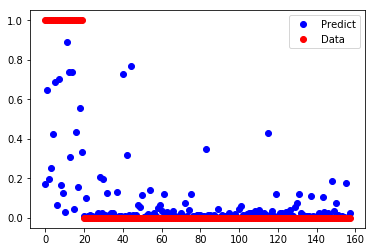

ROC
12 6 8 132
Weight


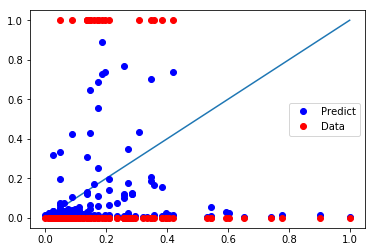

w[0] contour_len #1: 0.019587980583310127


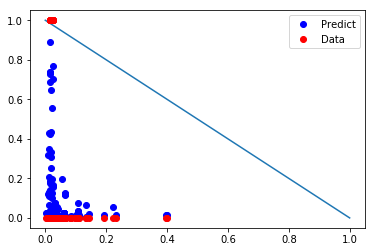

w[1] bounding_rect_ratio #1: -0.7596109509468079


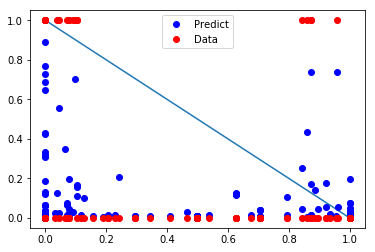

w[2] rotated_rect_angle #1: -0.5936964154243469


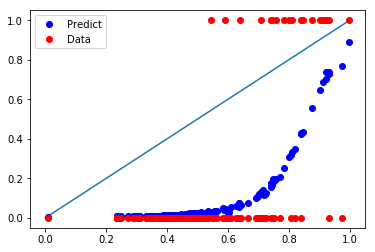

w[3] greyscale #1: 0.7181141972541809


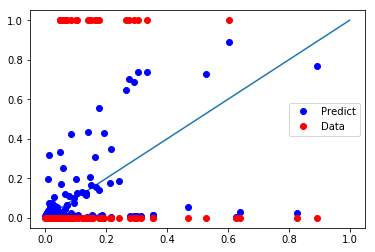

w[4] point_area #1: 0.3281994163990021


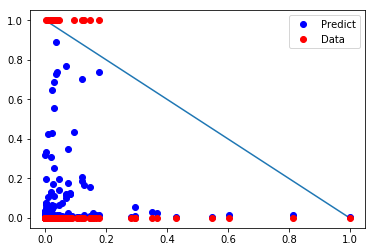

w[5] contour_len #1: -0.22058960795402527


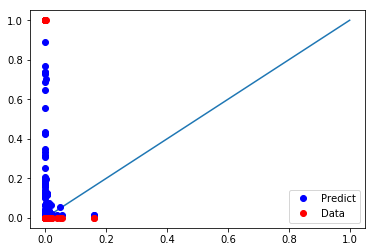

w[6] bounding_rect_ratio #2: 0.01723603717982769


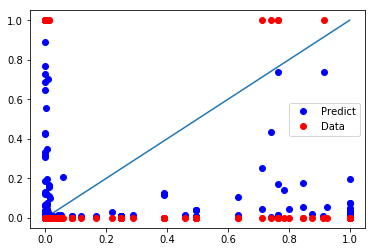

w[7] rotated_rect_angle #2: 0.23405490815639496


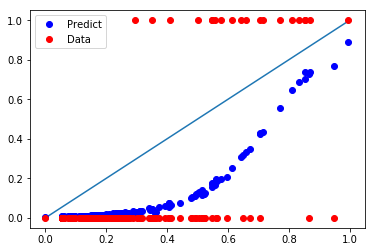

w[8] greyscale #2: 2.7807042598724365


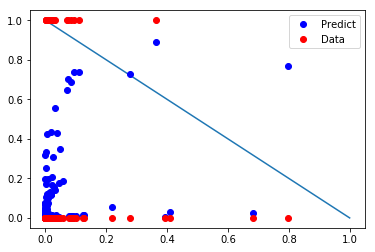

w[9] point_area #2: -0.5892988443374634


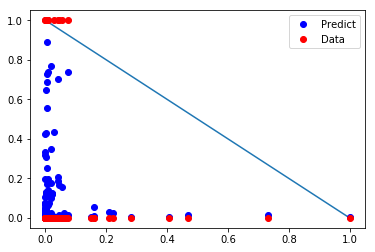

w[10] contour_len #2: -0.4461674094200134


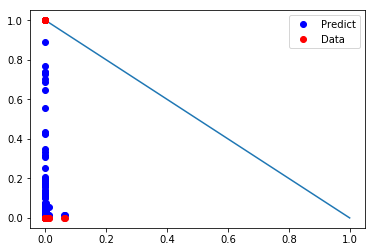

w[11] bounding_rect_ratio #2: -0.3011620342731476


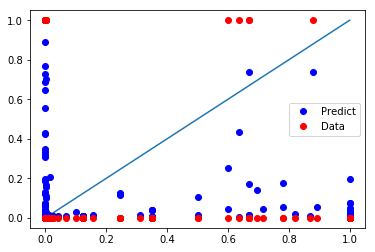

w[12] rotated_rect_angle #3: 0.49672067165374756


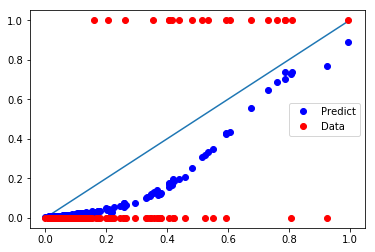

w[13] greyscale #3: 4.05984354019165


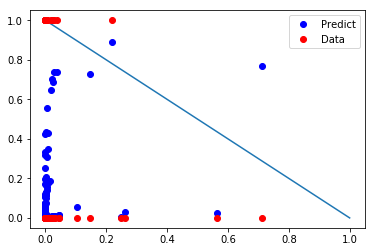

w[14] point_area #3: -0.5408844947814941


In [3]:
# Test
def analyse(x_anls, y_anls, threshold):
    # Predict
    y_pred = model(x_anls)

    # Convert to numpy array
    x_anls, y_anls, y_pred = (t.numpy() for t in [x_anls, y_anls, y_pred])

    # Sort
    _1,_2 = np.where(y_anls==1)[0],np.where(y_anls==0)[0]
    x_anls, y_anls, y_pred = (np.concatenate((t[_1,:],t[_2,:])) for t in (x_anls, y_anls, y_pred))

    # Distribution
    print('Data Distribution')
    x = np.arange(0, x_anls.shape[0], dtype=int)
    # x_anls = np.arange(0, 40, dtype=int)
    plt.plot(x, y_pred[x,:], 'bo', label='Predict')
    plt.plot(x, y_anls[x,:], 'ro', label='Data')
    plt.legend()
    plt.show()

    # ROC
    print('ROC')
    num_positive = len(np.where(y_anls==1)[0])
    num_negative = len(np.where(y_anls==0)[0])
    _ = np.where(y_pred>=threshold)[0]
    num_true_positive = len(np.where(y_anls[_,:]==1)[0])
    num_fasle_positive = len(np.where(y_anls[_,:]==0)[0])
    _ = np.where(y_pred<threshold)[0]
    num_true_negative = len(np.where(y_anls[_,:]==1)[0])
    num_fasle_negative = len(np.where(y_anls[_,:]==0)[0])
    print(num_true_positive,num_fasle_positive,num_true_negative,num_fasle_negative)

    # Weight
    x = np.linspace(0,1)
    w = [wi.data.cpu() for wi in model.parameters()]
    w = torch.cat((w[0][0],w[1])).numpy()
    print('Weight')
    b = w[-1]
    for i in range(input_size):
        a = w[i]
        y = a*x+b
        plt.plot(x, (y-y.min())/(y.max()-y.min()), linestyle='-')
        plt.plot(x_anls[:, i], y_pred, 'bo', label='Predict')
        plt.plot(x_anls[:, i], y_anls, 'ro', label='Data')
        plt.legend()
        plt.show()
        _1, _2 = i%(len(header) - 1), int(i/len(header)+1)
        print('w[{}] {} #{}: {}'.format(i, header[_1], _2, w[i]))

with torch.no_grad():
#     x_test, y_test,*_ = load('test.csv', 0)
    analyse(x_test, y_test, 0.2)
    